In [2]:
%matplotlib inline
from __future__ import print_function, division

import lsst.daf.persistence as dafPersist
import lsst.afw.math as afwMath
import lsst.afw.image as afwImage
import numpy as np
import matplotlib.pylab as plt

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (7.0, 5.5)
plt.rcParams['font.size'] = 16
plt.rcParams['axes.labelcolor'] = "#000000"

In [3]:
b = dafPersist.Butler("decam_calexps")

In [60]:
dataref = {"visit": 197367,
           "ccdnum": 20}

img = b.get("calexp", immediate=True, **dataref)


Per-pixel noise values
====

First check that the variance in pixel values (assumed to be mostly sky) is consistent with the reported variance plane, both in the calexps and the difference image.

In [55]:
sc = afwMath.StatisticsControl()
sc.setNumSigmaClip(5)
sc.setNumIter(3)
sc.setAndMask(afwImage.MaskU.getPlaneBitMask(["INTRP", "EDGE",
                                              "DETECTED", "BAD",
                                              "NO_DATA", "DETECTED_NEGATIVE"]))
stat_flags = afwMath.STDEV | afwMath.MEAN | afwMath.MEDIAN | \
             afwMath.VARIANCE | afwMath.STDEVCLIP

In [56]:
img_stats = afwMath.makeStatistics(img.getMaskedImage(), stat_flags, sc)
var_stats = afwMath.makeStatistics(img.getMaskedImage().getVariance(), stat_flags, sc)

print("Image mean, variance: ", img_stats.getValue(afwMath.MEAN),
      img_stats.getValue(afwMath.VARIANCE))
print("Variance plane median:", var_stats.getValue(afwMath.MEDIAN))


print("---")
print("Stddev is {:.1f}% higher than reported".format(
        100*(img_stats.getValue(afwMath.STDEV)/np.sqrt(var_stats.getValue(afwMath.MEDIAN)) - 1)))

#norm_stats = afwMath.makeStatistics(img.getMaskedImage().getImage()/img.getMaskedImage().getVariance(),
#                                    stat_flags, sc)
#print(var_stats.getValue(afwMath.MEDIAN))
print("Clipped Stddev is {:.1f}% higher than reported".format(
        100*(img_stats.getValue(afwMath.STDEVCLIP)/np.sqrt(var_stats.getValue(afwMath.MEDIAN)) - 1)))


Image mean, variance:  0.0150726961527 117.791169316
Variance plane median: 108.375518799
---
Stddev is 4.3% higher than reported
Clipped Stddev is 4.2% higher than reported


In [70]:
def compute_stddev_scaling(exp):
    mi = exp.getMaskedImage()
    img_arr = mi.getImage().getArray()
    img_mask = mi.getMask().getArray()
    var_arr = mi.getVariance().getArray()

    sel_ok, = np.where(img_mask.flatten() & stat_flags == 0)
    non_masked_values = img_arr.flatten()[sel_ok]
    non_masked_variances = var_arr.flatten()[sel_ok]
    
    rescaled_image = img_arr/np.sqrt(var_arr)
    return np.std(rescaled_image.flatten()[sel_ok])

def scaleVariance(maskedImage):
    """This is from pipe.tasks.coaddBase
    """
    variance = maskedImage.getVariance()
    sigNoise = maskedImage.getImage().getArray()/np.sqrt(variance.getArray())
    maskVal = maskedImage.getMask().getPlaneBitMask(["EDGE", "NO_DATA", ])
    good = (maskedImage.getMask().getArray() & maskVal) == 0
    # Robust measurement of stdev
    q1, q3 = np.percentile(sigNoise[good], (25, 75))
    stdev = 0.74*(q3 - q1)
    return stdev


print(compute_stddev_scaling(img))
print(scaleVariance(img.getMaskedImage()))

1.08103
1.08855568081


In [ ]:
diffim = b.get("deepDiff_differenceExp", immediate=True, **dataref)
warp = b.get("deepDiff_matchedExp", immediate=True, **dataref)

diffim_stats = afwMath.makeStatistics(diffim.getMaskedImage(), stat_flags, sc)
diffim_var_stats = afwMath.makeStatistics(diffim.getMaskedImage().getVariance(), stat_flags, sc)
warp_stats = afwMath.makeStatistics(warp.getMaskedImage(), stat_flags, sc)

print("Diffim mean, variance, reported variance: ", diffim_stats.getValue(afwMath.MEAN),
      diffim_stats.getValue(afwMath.VARIANCE), diffim_var_stats.getValue(afwMath.MEDIAN))
print("Warp mean, variance: ", warp_stats.getValue(afwMath.MEDIAN),
                warp_stats.getValue(afwMath.VARIANCE))

In [ ]:
afwMath.ST

Something is wrong with the diffim variance estimate, but that seems to be a calculation problem. We can look at the histogram of pixel values to check:

In [34]:
# Get all the pixels from the diffim, excluding masked pixels, and make histogram.
mi = diffim.getMaskedImage()

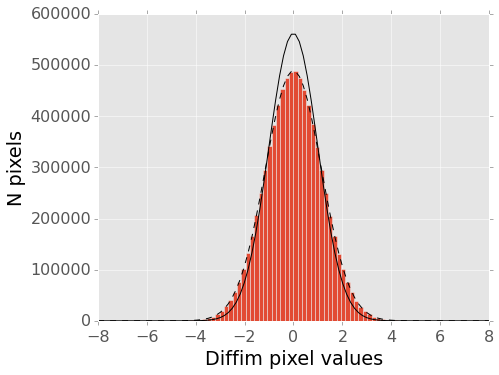

In [118]:
diffim = b.get("deepDiff_differenceExp", immediate=True, visit=197367, ccdnum=10)
img_arr = mi.getImage().getArray()
img_mask = mi.getMask().getArray()
var_arr = mi.getVariance().getArray()

sel_ok, = np.where(img_mask.flatten() & stat_flags == 0)
non_masked_values = img_arr.flatten()[sel_ok]
non_masked_variances = var_arr.flatten()[sel_ok]

#H,_,_ = plt.hist(non_masked_values, bins=90, range=(-50,50))
H,bins,_ = plt.hist(non_masked_values/np.sqrt(non_masked_variances), bins=90, range=(-8,8))

x = np.linspace(-8,8,100)
img_sigma = np.sqrt(diffim_var_stats.getValue(afwMath.MEDIAN))
img_sigma = 1.0
norm = sum(H)/np.sqrt(2*np.pi)/img_sigma * (bins[1] - bins[0])
plt.plot(x, norm * np.exp(-x**2/(2*img_sigma**2)), 'k-')

extra_factor = 1.15
plt.plot(x, norm/extra_factor * np.exp(-x**2/(2*(img_sigma*extra_factor)**2)), 'k--')
#plt.gca().set_yscale('log')
plt.xlabel("Diffim pixel values")
plt.ylabel("N pixels")

This is perhaps 15% higher than what's reported in the variance plane, but that's not particularly significant.

In [68]:
def focal_plane_pixel_histogram(butler, datasetId, n_ccds=59, do_rescale=False, **dataRef):
    bins = np.linspace(-8,8,90+1)
    H_total = np.zeros(len(bins) - 1)
    for ccdnum in xrange(1,n_ccds):
        exp = butler.get(datasetId, immediate=True, ccdnum=ccdnum, **dataRef)
        mi = exp.getMaskedImage()
        img_arr = mi.getImage().getArray()
        img_mask = mi.getMask().getArray()
        var_arr = mi.getVariance().getArray()

        sel_ok, = np.where(img_mask.flatten() & stat_flags == 0)
        non_masked_values = img_arr.flatten()[sel_ok]
        non_masked_variances = var_arr.flatten()[sel_ok]
    
        if do_rescale:
            #scale = compute_stddev_scaling(exp)
            scale = scaleVariance(mi)
        else:
            scale = 1.0
        H,_ = np.histogram(non_masked_values/(scale*np.sqrt(non_masked_variances)), bins=bins)
        H_total += H
    return H_total, bins

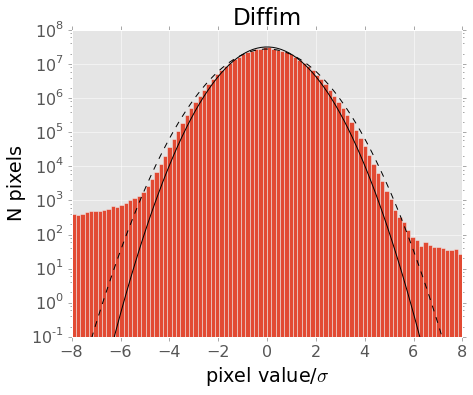

In [21]:
b_diffim = dafPersist.Butler("decam_diffims3")
H_total, bins = focal_plane_pixel_histogram(b_diffim, "deepDiff_differenceExp", visit=197367)

plt.bar(bins[:-1], H_total, width=1.0*(bins[1] - bins[0]),
    color=plt.gca()._get_lines.color_cycle.next())
plt.gca().set_yscale('log')

x = np.linspace(-8,8,100)
img_sigma = 1.0
norm = sum(H_total)/np.sqrt(2*np.pi)/img_sigma * (bins[1] - bins[0])
plt.plot(x, norm * np.exp(-x**2/(2*img_sigma**2)), 'k-')

extra_factor = 1.15
plt.plot(x, norm/extra_factor * np.exp(-x**2/(2*(img_sigma*extra_factor)**2)), 'k--')
plt.ylim(ymin=0.1)
plt.xlabel("pixel value/$\sigma$")
plt.ylabel("N pixels")
plt.title("Diffim")

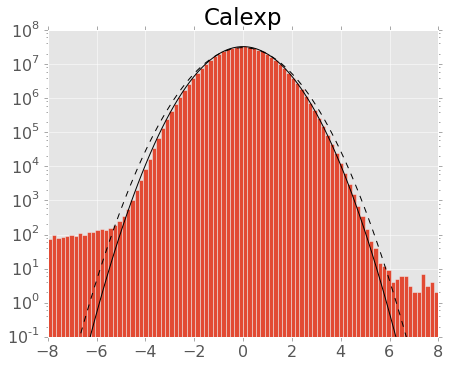

In [71]:
H_total, bins = focal_plane_pixel_histogram(b, "calexp", do_rescale=True, visit=197367)
plt.bar(bins[:-1], H_total, width=1.0*(bins[1] - bins[0]),
    color=plt.gca()._get_lines.color_cycle.next())
plt.gca().set_yscale('log')

x = np.linspace(-8,8,100)
img_sigma = 1.0
norm = sum(H_total)/np.sqrt(2*np.pi)/img_sigma * (bins[1] - bins[0])
plt.plot(x, norm * np.exp(-x**2/(2*img_sigma**2)), 'k-')

img_sigma = 1.07
norm = sum(H_total)/np.sqrt(2*np.pi)/img_sigma * (bins[1] - bins[0])
plt.plot(x, norm * np.exp(-x**2/(2*img_sigma**2)), 'k--')
plt.ylim(ymin=0.1)
plt.title("Calexp")

After Rescaling
-----

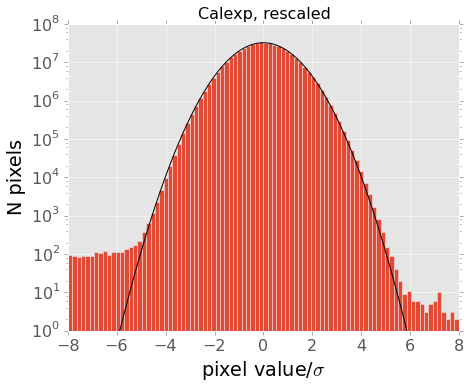

In [83]:
b_rescaled = dafPersist.Butler("decam_rescale_test")
H_total, bins = focal_plane_pixel_histogram(b_rescaled, "calexp", visit=197371)

plt.bar(bins[:-1], H_total, width=1.0*(bins[1] - bins[0]),
    color=plt.gca()._get_lines.color_cycle.next())
plt.gca().set_yscale('log')

x = np.linspace(-8,8,100)
img_sigma = 1.0
norm = sum(H_total)/np.sqrt(2*np.pi)/img_sigma * (bins[1] - bins[0])
plt.plot(x, norm * np.exp(-x**2/(2*img_sigma**2)), 'k-')
plt.ylim(ymin=1)
plt.title("Calexp, rescaled", fontsize="medium")
plt.xlabel(r"pixel value/$\sigma$")
plt.ylabel("N pixels")

Blank Sky Forced Photometry
====

We can also check the noise on PSF-sized areas by running force photometry on random patches of sky in the diffim.

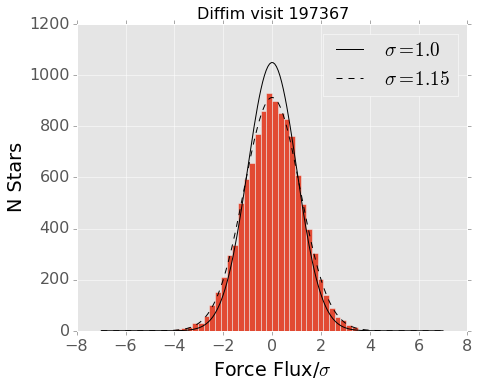

In [105]:
#bins = np.linspace(-500,500,41)
bins = np.linspace(-7,7,61)
H_total = np.zeros(len(bins) - 1)
for ccdnum in xrange(1,60):
    forced = b.get("forced_src", visit=197367, ccdnum=ccdnum)
    H,_ = np.histogram(forced['base_PsfFlux_flux']/forced['base_PsfFlux_fluxSigma'], bins=bins)
    H_total += H

# Worked this out from the plt.hist function. Orange is u'#E24A33'
plt.bar(bins[:-1], H_total, width=1.0*(bins[1] - bins[0]),
        color=plt.gca()._get_lines.color_cycle.next())
x = np.linspace(min(bins),max(bins),200)

phot_sigma = 1.0
#phot_sigma = np.median(forced['base_PsfFlux_fluxSigma'])
norm = sum(H_total)/np.sqrt(2*np.pi)/phot_sigma * (bins[1] - bins[0])
plt.plot(x, norm * np.exp(-x**2/(2*phot_sigma**2)), 'k-', label=r"$\sigma=1.0$")

extra_sigma = 1.15
plt.plot(x, norm/extra_sigma * np.exp(-x**2/(2*(phot_sigma*extra_sigma)**2)), 'k--',
         label=r"$\sigma={:.2f}$".format(extra_sigma))
plt.xlabel(r"Force Flux/$\sigma$")
plt.ylabel("N Stars")
plt.legend(loc=0)
plt.title("Diffim visit 197367", fontsize="medium")

In [73]:
instcal_exp = b.get("instcal", visit=197367, ccdnum=10, immediate=True)

In [75]:
stats = afwMath.makeStatistics(instcal_exp.getMaskedImage(), stat_flags, sc)

In [80]:
stats.getValue(afwMath.MEDIAN)

424.0022277832031